# Hierarchical Models Lab 1

##### Keywords: hierarchical, bayesian, empirical bayes, rat tumors, partial pooling,   exchangeability, beta, binomial, beta-binomial

In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import distributions
import matplotlib.pyplot as plt
import seaborn as sns
import time
sns.set_style('whitegrid')
sns.set_context('poster')

## Summary

Hierarchical models enable us to use gibbs sampling and priors which learn from data. We see how to set up such models using Gelman's rat tumors example. In this fashion statistically weak units such as low sample size experiments can be regularized towards the prior. 

Such shrinkage is observed both when the aproximate Empirical Bayes methodology is used to estimate the prior's parameters (hyper-parameters), and when we do a full bayesian analysis by putting weakly informative hyper-priors on the hyper-parameters. The exact mechanism of setting up the hierarchy in the model depends on the exchangeability of units in our analysis, but once we set it up, conditionals simply involve sampling from parents.

---

## An Example: Rats tumors (from [Gelman](http://www.stat.columbia.edu/~gelman/book/), chapter 5)


The below data is from tumors in female rats of type "F344" that recieve a particular drug, in 70 different experiments. 

The first column is the number that get the tumor; the second is the total number or rats tested

In [2]:
tumordata="""0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 19 
0 19 
0 19 
0 19 
0 18 
0 18 
0 17 
1 20 
1 20 
1 20 
1 20 
1 19 
1 19 
1 18 
1 18 
3 27 
2 25 
2 24 
2 23 
2 20 
2 20 
2 20 
2 20 
2 20 
2 20 
1 10 
5 49 
2 19 
5 46 
2 17 
7 49 
7 47 
3 20 
3 20 
2 13 
9 48 
10 50 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
10 48 
4 19 
4 19 
4 19 
5 22 
11 46 
12 49 
5 20 
5 20 
6 23 
5 19 
6 22 
6 20 
6 20 
6 20 
16 52 
15 46 
15 47 
9 24 
"""

In [3]:
tumortuples=[e.strip().split() for e in tumordata.split("\n")]
tumory=np.array([np.int(e[0].strip()) for e in tumortuples if len(e) > 0])
tumorn=np.array([np.int(e[1].strip()) for e in tumortuples if len(e) > 0])
tumory, tumorn            

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
         1,  1,  1,  1,  1,  3,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  5,
         2,  5,  2,  7,  7,  3,  3,  2,  9, 10,  4,  4,  4,  4,  4,  4,  4,
        10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  6,  6,  6, 16, 15,
        15,  9]),
 array([20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20,
        20, 19, 19, 18, 18, 27, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49,
        19, 46, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20,
        48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46,
        47, 24]))

Now, a 71st experiment is done and we are told that 4 out of 14 rats develop tumors. Our problem is  to estimate the risk of tumor in the rats in the 71st experiment .

Thus we are considering the problem of estimating the tumor rate from a small experiment (no 71) and a prior constructed from previous experiments with similar structure. Mathematically, we consider the current and historical experiments as random samples from a common population.

In [4]:
tumor_rat = [e[0]/e[1] for e in zip(tumory, tumorn)]
tmean = np.mean(tumor_rat)
tvar = np.var(tumor_rat)
tmean, tvar

(0.13600653889043893, 0.010557640623609196)

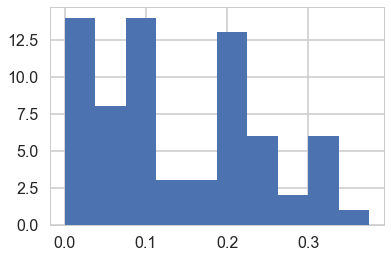

In [5]:
plt.hist(tumor_rat);

## Setting up the model


In the $j$-th historical experiment, let the number of rats with tumors be $y_j$ and the total number of rats be $n_j$.
Since the rats either have or dont have the tumor, it makes sense to use a Binomial Model for **each** experiment, assuming a sample size $n_j$ and a probability $\theta_j$ that a rat has a tumor. For any one of the experiments

$$p(y_i|\theta_i; n_i) =  Binom(n_i, y_i, \theta_i) $$

and for all the data we have, using $Y=[y_1,\ldots, y_{70}]$ and $\Theta = [\theta_1, \ldots, \theta_{70}]$ and I use the notation
$\{n_i\} =[n_1, \ldots, n_{70}]$

$$ p(Y|\Theta; \{n_i\}) =  \prod_{i=1}^{70}Binom(n_i, y_i, \theta_i) $$

We now need to choose a prior $p(\Theta)$. 

### No Pooling

Our first thought might be to use a Beta (conjugate prior to Binomial) for each $\theta_i$, i.e.

$$ \theta_i \sim Beta(\alpha_i, \beta_i).$$

$$p(\Theta| \{\alpha_i\}, \{\beta_i\}) = \prod_{i=1}^{70} Beta(\theta_i, \alpha_{i}, \beta_{i}),$$

where $\alpha_i$ and $\beta_i$ are what we called **hyperparameters**. Again I use the notation $\{\alpha_i\}=[\alpha_1, \ldots, \alpha_{70} ]$ and similarly for $\{beta\}$.

However, we would then come up with a very overfit model with 210 parameters and not much data. Besides, there are likely outliers in some experiments, small sample sizes, etc.

In your standard bias-variance tradeoff view of things this is a  model with a large amount of variance.

### Full pooling

The other extreme is to assume that there is only one $\theta$ in the problem, and set an prior on it, making this a three parameter problem. This ignores any variation amongst the sampling units other than sampling variance. Thus such a model might thus be underfit, unable to capture the variations in the samples. This is likely a model with a large amount of variance

## Partial pooling and the hierarchical model

Let us compromise and assume that the $\theta_i$s are drawn from a "population distribution" given by a conjugate Beta prior $Beta(\alpha, \beta)$ with parameters $\alpha$ and $\beta$ to describe this data.

$$ \theta_i \sim Beta(\alpha, \beta).$$


$$p(\Theta | \alpha, \beta) = \prod_{i=1}^{70} Beta(\theta_i, \alpha, \beta).$$

This structure is shown in the diagram below.

![](images/rat-tumor-hier2.png)

(image from http://seor.vse.gmu.edu/~klaskey/SYST664/Bayes_Unit7.pdf)

Such a model is called a **hierarchical** model, with observable outcomes modeled conditionally on certain parameters($\theta$s) which themselves are given a probabilistic specification in terms of further parameters ($\alpha$ and $\beta$), known as **hyperparameters**.



###  Priors from data

Now, to complete the story, we need to ask, where do $\alpha$ and $\beta$ come from? Why are we calling them hyperparameters? So far, in all the bayesian models we have created, we have assumed known values of the "hyperparameters" in the priors. The criteria for the values we have used have been to create either uninformative or weakly-informative(weakly-regularizing) priors.

Now we wish to estimate the parameters of these priors themselves from the data. This seems to contravene the Bayesian idea. Why would we want to do this?

The key idea here is that some of our **units** (experiments in our example) are statistically more robust than others. The non-robust experiments may have smaller samples or outlier like behavior, for example. What we wish to do is to borrow strength from all the data as a whole through the estimation of the hyperparameters. In this sense, our procedure will help us create a **regularized partial pooling model** in which the "lower level" (closer to data) parameter ($\theta$s) estimations are tied together by "upper level" parameters.

## Empirical Bayes

Our first idea to this is to simply estimate these hyperparameters ($\alpha$ and $\beta$) directly from the data. The idea here is simple. We find the posterior-predictive distribution, as a function of these upper level parameters. Lets call these parameters $\eta$ (in our case $\eta = (\alpha, \beta)$).

Then, for some "new" data $y^*$:

$$p(y^* \vert  D, \eta) = \int d\theta \, p(y^* \vert \theta) \, p(\theta \vert D, \eta)$$

We notice that this looks like a likelihood with parameters $\eta$ and simply use maximum-likelihood with respect to $\eta$ to estimate these $\eta$ using our "data" $y^*$. But note that, unlike in cross-validation in machine learning, where we have already determined $\theta$ on the training set, we have not determined $\theta$ yet here. Indeed, instead of optimizing  on $\theta$, we have marginalized over them. So we can do the optimization to find $\eta$ directly on our training set, or sample, itself.

This method is called **Emprical Bayes** or **Type-2 Maximum Likelihood**.

In practice, we often match moments of the hyperparameter likelihood with our data. In our example, there are two parameters $\alpha$ and $\beta$ to be estimated. By computing the mean and the variance of the type-2 likelihood (the posterior predictive as a function of the hyperparameters) we can solve for both $\alpha$ and $\beta$. Sometimes we will use the prior instead: it depends on the meaning of either distribution.

### Moment Matching

So which distribution do you use to moment-match, if you are not doing a type-2 MLE?

It depends on your data. If your data is on the y-scale, often the prior predictive. If its on a ratio scale (p/n) often the prior scale. For the rat tumors, it is not possible to create an idealized experimental $n_i$, so we use the prior since the beta distribution is on the scale of the thetas. The mean of the Beta prior is matched to the data mean, and the variance of the beta prior is matched to the data variance. In this way we have x=created a pooled estimate, but by doing it on the prior we have pushed it one level up the "hierarchy" stack. Now the binomial multiplies this beta prior, and we get a new beta posterior per experiment, and those means reflect our **regularised** $\theta$ estimates

### Working moment-matching based Empirical Bayes rat tumors

![](images/ratsempbayes.png)

(image from http://seor.vse.gmu.edu/~klaskey/SYST664/Bayes_Unit7.pdf)

We'll insert point estimates from the method of moments, used on the prior distribution. Since the prior  is the beta distribution, we need to find the mean and variance of it:

$$\mu =  \frac{\alpha}{\alpha + \beta}$$

and

$$V  = \frac{\alpha\beta}{(\alpha + \beta)^2 (\alpha + \beta + 1)}$$

Note that there are different ratios for each experiment, and we are taking the average of these.

In [11]:
aplusb = tmean*(1-tmean)/tvar - 1
a_est=aplusb*tmean
b_est=aplusb*(1.0 - tmean)
a_est, b_est

(1.3777748392916778, 8.7524354471531129)

We can now use these to compute the posterior means for all the experiments.

The conditional posterior distribution for each of the $\theta_i$, given everything else is a Beta distribution itself (remember Beta is conjugate prior to Bionomial).

$p(\theta_i | y_i, n_i, \alpha, \beta) = Beta(\alpha + y_i, \beta + n_i - y_i)$ 

Thus the posterior mean is

$$\bar{\theta}_{post, i} = \frac{\alpha + y_i}{\alpha + \beta + n_i}$$

In [12]:
post_means = (a_est + tumory)/(a_est + b_est + tumorn)

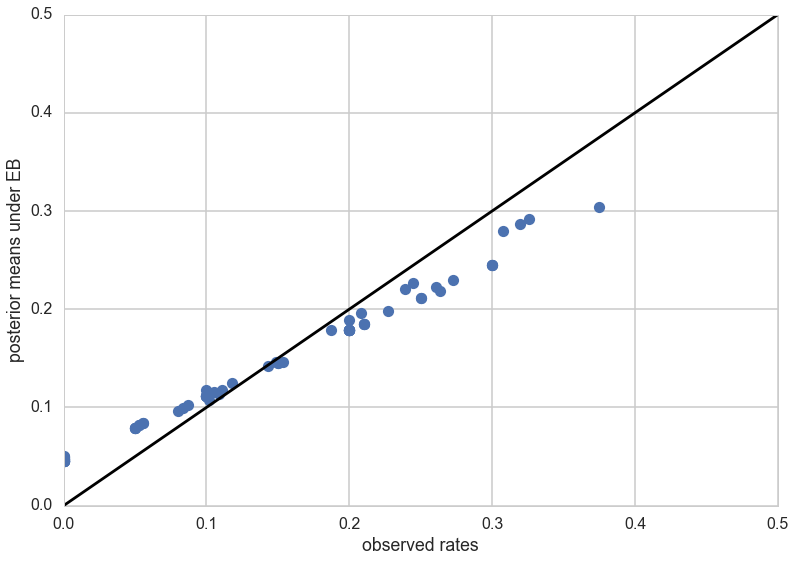

In [13]:
plt.plot(tumor_rat, post_means,'o')
plt.plot([0,0.5],[0,0.5],'k-')
plt.xlabel("observed rates")
plt.ylabel("posterior means under EB");

As you can see, the posterior rates are shrunk towards flatness, which would correspond to complete pooling. The 45 degree line would be for completely unpooled estimate.

Now, for the 71st experiment, we have 4 out of 14 rats having tumors. The posterior estimate for this would be

$$\frac{\alpha + y_{71}}{\alpha + \beta + n_{71}}$$

In [15]:
4/14, (4+a_est)/(14+a_est+b_est)

(0.2857142857142857, 0.22286481449822493)

So we would revise our estimate downwards for this experiment.

## Exchangeability

The iid assumption in statistics is an assumption that the values $y_i$ that go into a density (or likelihood) are **exchangeable**. That is, the likelihood is invariant to the permutation of data indices. If one has covariates, we are then talking about the joint density $p(x,y)$ or $p(x,y \vert \theta)$ and it is $(x,y)$ thats assumed to be the unit of permutation. 

In practice, ignorance implies exchangeability. Maximal exchangeability is indeed the argument underlying maximum entropy.

In hierarchical models, we use the notion of exchangeability at the level of 'units'. By units we mean an observationally cohesive bunch of data. For example, our unit may be observations in a particular experiment, and then hierarchically, we might talk about exchangeability between different experiments. For our rats, the $y_j$ were exchangeable since we had no additional information about experimental conditions. But if we knew that specific groups of experiments came from specific laboratories, we would now only assume partial exchangeability. We'd assume that experiments were interchangeable if they came from the same lab. So then we'd have lab specific $\alpha$ and $\beta$ parameters, and add another level of hierarchy to figure how these might themselves be drawn from some common distribution.